# Neural networks, Checkpoint 

Faculty: FIIT <br>
Academic year: 2019/2020 <br>
Authors: Andrej Gáfrik, Martin Grega <br>


We had to change out source data to https://figshare.com/articles/Wikipedia_Detox_Data/4054689, because of bad formatting in data, which we couldn't solve.

In [55]:
# !pip install pandas
# !pip install nltk
# !pip install tokenizer
#!pip uninstall keras
#!pip install keras --upgrade
#!pip install sklearn
#!pip install h5py

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:


import os
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
comments = pd.read_csv('../../data/attack_annotated_comments.tsv', sep='\t')
labels = pd.read_csv('../../data/attack_annotations.tsv', sep='\t')

In [8]:
jupyter notebook list

SyntaxError: invalid syntax (<ipython-input-8-46cbd787b5a9>, line 1)

In [ ]:
comments = comments.drop(columns=['year','logged_in','ns','sample','split'])

In [ ]:
comments

Problems in data:
 - tabular, new line and qoutes were replaced with tab_token, new_line token and `
 - punctuation
 - more spaces between words
 - empty strings
 - abbreviations like i will = i'll , didn't = did not, ...

In [ ]:
labels = labels.drop(columns=['worker_id','quoting_attack','recipient_attack','third_party_attack','other_attack'])

In [ ]:
labels



In [ ]:
res = labels.groupby('rev_id')['attack'].mean().reset_index()

In [ ]:
res

In [ ]:
data = comments.join(res.set_index('rev_id'), on='rev_id')
data['attack'] = data['attack'].round(0)

In [ ]:
data

In [ ]:
data.info()
data.isnull().values.any()

In [ ]:
# In out data are newlines, tabulators and quotions marks replaced, so we need to delete this replacement
data['comment'] = data['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN",""))
data['comment'] = data['comment'].apply(lambda x: x.replace("TAB_TOKEN",""))
data['comment'] = data['comment'].apply(lambda x: x.replace("``",'"'))

In [ ]:
# Source: https://www.kaggle.com/prashantkikani/pooled-gru-with-preprocessing
repl = {
    "&lt;3": " good ",
    ":d": " good ",
    ":dd": " good ",
    ":p": " good ",
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    "yay!": " good ",
    "yay": " good ",
    "yaay": " good ",
    "yaaay": " good ",
    "yaaaay": " good ",
    "yaaaaay": " good ",
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":s": " bad ",
    ":-s": " bad ",
    "&lt;3": " heart ",
    ":d": " smile ",
    ":p": " smile ",
    ":dd": " smile ",
    "8)": " smile ",
    ":-)": " smile ",
    ":)": " smile ",
    ";)": " smile ",
    "(-:": " smile ",
    "(:": " smile ",
    ":/": " worry ",
    ":&gt;": " angry ",
    ":')": " sad ",
    ":-(": " sad ",
    ":(": " sad ",
    ":s": " sad ",
    ":-s": " sad ",
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
    r"\bi'm\b": "i am",
    "m": "am",
    "r": "are",
    "u": "you",
    "haha": "ha",
    "hahaha": "ha",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "can't": "can not",
    "cannot": "can not",
    "i'm": "i am",
    "m": "am",
    "i'll" : "i will",
    "its" : "it is",
    "'s" : " is",
    "'s" : " is",
    "`d": " would",
    "that's" : "that is",
    "weren't" : "were not",
    "e.g" : "eg",
}

In [ ]:
#splitting comments by spaces
comments = data['comment'].apply(lambda x: x.split())

In [ ]:
import re
abbr = [i for i in repl.keys()]
result = []
for index in range(len(comments)):
    new_comment = ""
    for word in comments[index]:
        word = word.lower()
        word = re.sub(r"n't", " not", word)
        word = re.sub(r"\ 's", " not", word)
        word = re.sub(r"\ 've", " not", word)
        word = re.sub(r"\ 'd", " not", word)
        word = re.sub(r"\ ll", " not", word)
        if re.search("^http.+|^www.+",word): # deleting links
            continue
        elif word in abbr:
            new_comment += repl[word]
            new_comment += " "
            word = repl[word]
        elif re.search("[^a-zA-Z ]+",word): # only alphabet
            new_comment += re.sub("[^a-zA-Z ]+"," ",word)
            new_comment += " "
        else:
            new_comment += word  
            new_comment += " "
            
    new_comment = " ".join(new_comment.split())        
   # print("Old = ", comments[index])
   # print("New = ", new_comment)
    result.append(new_comment)
data["comment"] = result

In [ ]:
pd.options.display.max_rows = 999
data

In [ ]:
# replacing empty strings with nan
data['comment'].replace('', np.nan, inplace=True)

In [ ]:
# checking nan values on data
data.info()
data.isnull().values.any()

In [ ]:
# drop nan rows
data.dropna(subset=['comment'], inplace=True)
data = data.reset_index(drop=True)

# Stemming

In [ ]:
from nltk.stem import SnowballStemmer

def stemmer(comment):
    stemmer = SnowballStemmer('english')
    words = comment.split()
    stemmed = [stemmer.stem(word) for word in words]
    stemmed
    return " ".join(stemmed)

t = data['comment'].map(lambda x: stemmer(x))

In [ ]:
data['stemmed_comments'] = t

In [66]:
data['number_of_words'] = data.stemmed_comments.apply(lambda x: len(x.split()))

In [89]:
data = data.loc[data['number_of_words'] <= 300]

In [90]:
data.loc[data['number_of_words'].idxmax()]

rev_id                                                        6360046
comment             wikipedia is an encyclopedia not a dictionary ...
attack                                                              0
stemmed_comments    wikipedia is an encyclopedia not a dictionari ...
number_of_words                                                   300
Name: 479, dtype: object

In [102]:
data['attack'].value_counts()

0.0    98887
1.0    13206
Name: attack, dtype: int64

In [101]:
# saving cleaned data
data.to_csv('../../data/preprocessed_data_1.csv', encoding='utf-8')

# Tokenizing

In [3]:
data= pd.read_csv('../../data/preprocessed_data_1.csv', index_col=0)

In [4]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize

In [5]:
tokenizer = Tokenizer()

# Training of our tokenizer
tokenizer.fit_on_texts(data['stemmed_comments'])
#tokenizer.fit_on_texts(data['comment'])

# Number of unique words in our data
vocab_len = len(tokenizer.word_index) + 1

#converting comment into numeric form, each unique word has a number, so comment will be rewrite into numbers
embedded = tokenizer.texts_to_sequences(data['stemmed_comments'])

In [6]:
longest_sentence_len = len(max(embedded, key= len))

#Adding zeroes to end of eat embeded sentece to len of the longest sentence
padded_comments = pad_sequences(embedded, longest_sentence_len, padding='post')

# Glove embeddings

In [7]:
glove = open('../../data/glove.6B.100d.txt', encoding="utf8")
from numpy import array
from numpy import asarray

In [8]:
# Train and test data
size_train = round(len(padded_comments)* 0.8)

train_padded = padded_comments[:size_train]
train_attack =asarray(data['attack'][:size_train], dtype='int32')

test_padded = padded_comments[size_train + 1:]
test_attack = asarray(data['attack'][size_train + 1:], dtype='int32')

In [9]:
unique, counts = np.unique(train_attack, return_counts=True)
dict(zip(unique, counts))

{0: 78913, 1: 10761}

In [10]:
unique, counts = np.unique(test_attack, return_counts=True)
dict(zip(unique, counts))

{0: 19973, 1: 2445}

In [11]:
# Preparing glove dictonary
glove_dict = dict()

#according to glove file, first is word and next are vectors
for line in glove:
    splitted = line.split()
    word = splitted[0]
    vectors = asarray(splitted[1:], dtype='float32')
    glove_dict [word] = vectors 


glove.close()

In [12]:
from numpy import zeros
zle = 0
# create dict with only words in out data
word_matrix = zeros((vocab_len, 100))
# iterate throuh all words in our data and find vector for them
for word, index in tokenizer.word_index.items():
    vectors = glove_dict.get(word)
    if vectors is not None:
        word_matrix[index] = vectors # pretrained word embedings with words from our comments
        

# GRU 

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,GRU,Dense
from tensorflow.keras.initializers import Constant
from sklearn.utils import class_weight
from datetime import datetime

def GRU_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_len,100,embeddings_initializer = Constant(word_matrix),input_length=longest_sentence_len,trainable=False)
    model.add(embedding_layer)
    model.add(GRU(units = 64, dropout = 0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'], learning_rate = 0.005)
    return model


In [14]:
model = GRU_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          9365400   
_________________________________________________________________
gru (GRU)                    (None, 64)                31872     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 9,397,337
Trainable params: 31,937
Non-trainable params: 9,365,400
_________________________________________________________________


In [15]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_attack),
                                                 train_attack)

In [16]:
np.unique(train_attack, return_counts=True)

(array([0, 1], dtype=int32), array([78913, 10761]))

In [17]:
weights = {0: class_weights[0], 1: class_weights[1]}
weights

{0: 0.5681826821943152, 1: 4.166620202583403}

In [40]:
# logging for GRU model, 
#TU zmen GRu_7 na novy priecinok
logdir = "../../logs/GRU_7/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0,profile_batch=0)

#Not working in notebook and docker, trained in google colab, screen of results in model
history = model.fit(train_padded,train_attack,batch_size=128, epochs=15, 
          validation_data=(test_padded,test_attack),verbose=1, class_weight=weights, callbacks=[tensorboard_callback])

Train on 89674 samples, validate on 22418 samples
Epoch 1/15
89674/89674 [==============================] - 43s 483us/sample - loss: 0.2501 - accuracy: 0.4764 - val_loss: 0.2407 - val_accuracy: 0.1108
Epoch 2/15
89674/89674 [==============================] - 41s 458us/sample - loss: 0.1617 - accuracy: 0.6582 - val_loss: 0.0935 - val_accuracy: 0.8751
Epoch 3/15
89674/89674 [==============================] - 41s 459us/sample - loss: 0.0998 - accuracy: 0.8687 - val_loss: 0.0880 - val_accuracy: 0.8864
Epoch 4/15
89674/89674 [==============================] - 41s 460us/sample - loss: 0.0930 - accuracy: 0.8775 - val_loss: 0.0855 - val_accuracy: 0.8921
Epoch 5/15
89674/89674 [==============================] - 41s 458us/sample - loss: 0.0902 - accuracy: 0.8799 - val_loss: 0.0829 - val_accuracy: 0.8926
Epoch 6/15
89674/89674 [==============================] - 41s 459us/sample - loss: 0.0866 - accuracy: 0.8851 - val_loss: 0.0841 - val_accuracy: 0.9145
Epoch 7/15
89674/89674 [====================

In [19]:
import matplotlib.pyplot as plt

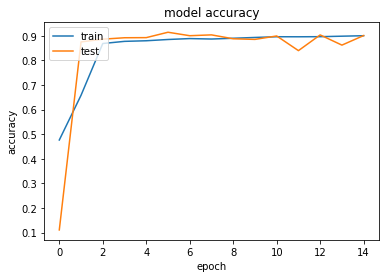

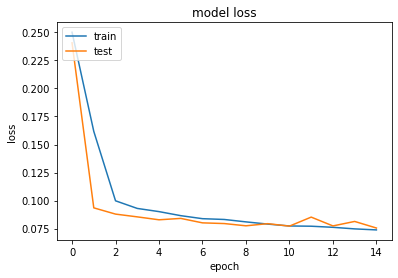

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
#Vytvor priecinok novy a tu zmen GRU_7 na svoj novy priecinok vzdy ekd mas novy model
model_json = model.to_json()
with open("../../models/GRU_7/model_GRU.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("../../models/GRU_7/model_GRU.h5")

# SimpleRNN

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,SimpleRNN, LSTM, Bidirectional, Masking
from tensorflow.keras.initializers import Constant

def LSTM_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_len,100,embeddings_initializer = Constant(word_matrix),input_length=longest_sentence_len,trainable=False)
    model.add(embedding_layer)
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(64, return_sequences=False, dropout=0.1))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [64]:
model2 = LSTM_model()
model2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 300, 100)          9365400   
_________________________________________________________________
masking_7 (Masking)          (None, 300, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 9,407,705
Trainable params: 42,305
Non-trainable params: 9,365,400
_________________________________________________________________


In [65]:
logdir = "../../logs/lstm_1/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0,profile_batch=0)

model2.fit(train_padded,train_attack,batch_size=128, epochs=3, 
          validation_data=(test_padded,test_attack),verbose=1, class_weight=weights, callbacks=[tensorboard_callback])

Train on 89674 samples, validate on 22418 samples
Epoch 1/3
89674/89674 [==============================] - 295s 3ms/sample - loss: 0.1318 - accuracy: 0.8323 - val_loss: 0.1102 - val_accuracy: 0.9105
Epoch 2/3
89674/89674 [==============================] - 287s 3ms/sample - loss: 0.1000 - accuracy: 0.8633 - val_loss: 0.0944 - val_accuracy: 0.9033
Epoch 3/3
89674/89674 [==============================] - 287s 3ms/sample - loss: 0.0895 - accuracy: 0.8778 - val_loss: 0.0890 - val_accuracy: 0.9069


# Data resampling

In [14]:
from sklearn.utils import resample
np.unique(train_attack, return_counts = True)


(array([0, 1], dtype=int32), array([78913, 10761]))

In [66]:
resampled_train_attack = []
resampled_train_padded = []

y = np.bincount(train_attack)
difference = y[0] - y[1]
num_attacks = 0

for i in range(y[0]+y[1]):
    
    if(train_attack[i]==1):
        resampled_train_padded.append(train_padded[i])
        resampled_train_attack.append(train_attack[i])
    elif(train_attack[i]==0 and num_attacks < y[1]):
        resampled_train_padded.append(train_padded[i])
        resampled_train_attack.append(train_attack[i])
        num_attacks = num_attacks + 1
        
        
resampled_test_attack = []
resampled_test_padded = []

y = np.bincount(test_attack)
difference = y[0] - y[1]
num_attacks = 0

for i in range(y[0]+y[1]):
    
    if(test_attack[i]==1):
        resampled_test_padded.append(test_padded[i])
        resampled_test_attack.append(test_attack[i])
    elif(test_attack[i]==0 and num_attacks < y[1]):
        resampled_test_padded.append(test_padded[i])
        resampled_test_attack.append(test_attack[i])
        num_attacks = num_attacks + 1        

In [68]:
np.asarray(resampled_test_attack).shape

(4890,)

# SimpleRNN model

In [73]:
from tensorflow.keras.layers import Embedding,Dense,SimpleRNN, Masking, LSTM

def Simple_RNN():
    model = Sequential()
    embedding_layer = Embedding(vocab_len,100,embeddings_initializer = Constant(word_matrix),input_length=longest_sentence_len,trainable=False)
    model.add(embedding_layer)
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(16, recurrent_dropout=0.15))
    model.add(Dense(16,activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [74]:
model3 = Simple_RNN()
model3.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 300, 100)          9365400   
_________________________________________________________________
masking_12 (Masking)         (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                7488      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 9,373,177
Trainable params: 7,777
Non-trainable params: 9,365,400
_________________________________________________________________


In [76]:
model3.fit(np.asarray(resampled_train_padded),np.asarray(resampled_train_attack),batch_size=128, epochs=20, 
          validation_data=(np.asarray(resampled_test_padded),np.asarray(resampled_test_attack)),verbose=1)

Train on 21522 samples, validate on 4890 samples
Epoch 1/20
21522/21522 [==============================] - 73s 3ms/sample - loss: 0.0917 - accuracy: 0.8774 - val_loss: 0.1076 - val_accuracy: 0.8552
Epoch 2/20
21522/21522 [==============================] - 72s 3ms/sample - loss: 0.0887 - accuracy: 0.8815 - val_loss: 0.1012 - val_accuracy: 0.8620
Epoch 3/20
21522/21522 [==============================] - 72s 3ms/sample - loss: 0.0856 - accuracy: 0.8859 - val_loss: 0.1038 - val_accuracy: 0.8603
Epoch 4/20
21522/21522 [==============================] - 71s 3ms/sample - loss: 0.0837 - accuracy: 0.8893 - val_loss: 0.1000 - val_accuracy: 0.8681
Epoch 5/20
21522/21522 [==============================] - 72s 3ms/sample - loss: 0.0807 - accuracy: 0.8936 - val_loss: 0.1012 - val_accuracy: 0.8613
Epoch 6/20
21522/21522 [==============================] - 71s 3ms/sample - loss: 0.0800 - accuracy: 0.8950 - val_loss: 0.0996 - val_accuracy: 0.8616
Epoch 7/20
21522/21522 [==============================] -